GitHub: https://github.com/bevanyeah/assignments


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [371]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [4]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


# Build the model

Let's define a tokenizer and read the data from disk.

In [373]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [374]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [375]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [376]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [377]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [378]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [379]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [380]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [381]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [382]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [383]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    ### START CODE HERE ###

    model = Sequential()
    model.add(Embedding(input_dim=total_words, output_dim=128))
    model.add(LSTM(128))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

    ### END CODE HERE ### 
    
#Print details of the model.
model = deep_fake_comment_model()

Now, let's start our training.

In [384]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Train on 4030 samples
Epoch 1/200
4030/4030 [==============================] - 27s 7ms/sample - loss: 6.4036 - accuracy: 0.0677
Epoch 2/200
4030/4030 [==============================] - 24s 6ms/sample - loss: 5.8799 - accuracy: 0.0749
Epoch 3/200
4030/4030 [==============================] - 24s 6ms/sample - loss: 5.7335 - accuracy: 0.0950
Epoch 4/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 5.5964 - accuracy: 0.1144
Epoch 5/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 5.4218 - accuracy: 0.1266
Epoch 6/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 5.2463 - accuracy: 0.1385
Epoch 7/200
4030/4030 [==============================] - 24s 6ms/sample - loss: 5.0678 - accuracy: 0.1588
Epoch 8/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 4.8922 - accuracy: 0.1715
Epoch 9/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 4.7226 - accuracy: 0.1799
Epoch 10/200
4030/4030 [

4030/4030 [==============================] - 27s 7ms/sample - loss: 0.1846 - accuracy: 0.9489
Epoch 78/200
4030/4030 [==============================] - 26s 6ms/sample - loss: 0.1818 - accuracy: 0.9491
Epoch 79/200
4030/4030 [==============================] - 28s 7ms/sample - loss: 0.1782 - accuracy: 0.9474
Epoch 80/200
4030/4030 [==============================] - 26s 6ms/sample - loss: 0.1740 - accuracy: 0.9486
Epoch 81/200
4030/4030 [==============================] - 27s 7ms/sample - loss: 0.1729 - accuracy: 0.9474
Epoch 82/200
4030/4030 [==============================] - 28s 7ms/sample - loss: 0.1701 - accuracy: 0.9481
Epoch 83/200
4030/4030 [==============================] - 26s 6ms/sample - loss: 0.1678 - accuracy: 0.9481
Epoch 84/200
4030/4030 [==============================] - 30s 7ms/sample - loss: 0.1724 - accuracy: 0.9476
Epoch 85/200
4030/4030 [==============================] - 26s 7ms/sample - loss: 0.1775 - accuracy: 0.9459
Epoch 86/200
4030/4030 [==========================

4030/4030 [==============================] - 24s 6ms/sample - loss: 0.1275 - accuracy: 0.9496
Epoch 154/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 0.1276 - accuracy: 0.9486
Epoch 155/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 0.1275 - accuracy: 0.9484
Epoch 156/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 0.1268 - accuracy: 0.9504
Epoch 157/200
4030/4030 [==============================] - 23s 6ms/sample - loss: 0.1270 - accuracy: 0.9484
Epoch 158/200
4030/4030 [==============================] - 25s 6ms/sample - loss: 0.1273 - accuracy: 0.9499
Epoch 159/200
4030/4030 [==============================] - 25s 6ms/sample - loss: 0.1272 - accuracy: 0.9494
Epoch 160/200
4030/4030 [==============================] - 25s 6ms/sample - loss: 0.1266 - accuracy: 0.9501
Epoch 161/200
4030/4030 [==============================] - 26s 7ms/sample - loss: 0.1266 - accuracy: 0.9509
Epoch 162/200
4030/4030 [=================

Let's plot details of our training.

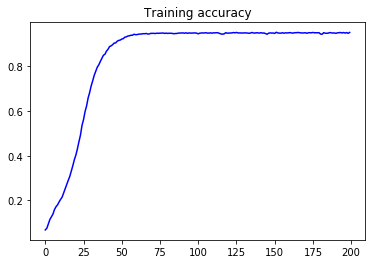

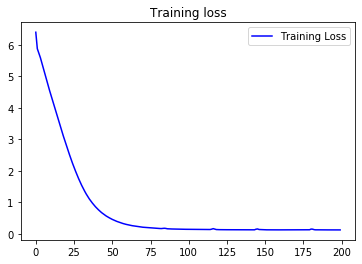

In [385]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [386]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    ### START CODE HERE ###
    
    #First, split string into input array of tokens
    tokens = np.asarray(tokenizer.texts_to_sequences([seed_text])[0])
    
    #We need to cut off the first tokens later, so record length now
    original_count = len(tokens)
    
    #Loop until max seq len has been reached, we may exit sooner
    for loop in range(max_sequence_len):
        
        #With our tokens array, we want to pad
        padded = pad_sequences([tokens], maxlen=max_sequence_len, padding='pre')
    
        #Feed into trained model to get prediction for next word
        predict = model.predict_classes(padded,batch_size=32)
        
        #Append the next word to the tokens list (without the padding)
        tokens = np.append(tokens, predict[0])
        
        #If the predicted next word is EOS ('.'), we need to generate the string and return it
        if reverse_word_map[predict[0]] == '.' or loop == max_sequence_len:
            #Build our coherant string, starting with the original string
            return_string = seed_text
            
            #strip the tokens from the first part of token array, because we added the string directly
            tokens = tokens[original_count:]
                
            for i in range(len(tokens[:])):
                #If next string is a fullstop, add it and return string
                if reverse_word_map[tokens[i]] == '.':
                    return_string += '.'
                    return(return_string)
                elif reverse_word_map[tokens[i]] == ',':
                    #no space, add comma
                    return_string += ','
                else:
                    #add a space then add the string
                    return_string += ' '
                    return_string += reverse_word_map[tokens[i]]
                    
            #if somehow we haven't seen a '.', return the string we have anyway
            return(return_string)


    ### END CODE HERE ### 

**Let's test it:**

In [387]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))


COVID19 virus cannot be transmitted in areas with hot and humid climates.
COVID19 is the deadliest virus known to humans.
The usa is the covid19 was caused by an accidental leak from wuhan virus research institute.
The new virus was engineered by scientists in a lab.


**Let's test it in an interactive mode:**

In [388]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: Covid19 is not
Covid19 is not covid 1, folks. 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [389]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
   ### START CODE HERE ### 
   
    #First, split string into input array of tokens
    tokens = np.asarray(tokenizer.texts_to_sequences([seed_text])[0])
    
    #We need to cut off the first tokens later, so record length now
    original_count = len(tokens)
    
    #Loop until max seq len has been reached, we may exit sooner
    for loop in range(max_sequence_len):
        
        #With our tokens array, we want to pad
        padded = pad_sequences([tokens], maxlen=max_sequence_len, padding='pre')
    
        #Feed into trained model to get probability of prediction
        predict_Prob = model.predict_proba(padded,batch_size=32)

        #Select random choice using array of prediction probabilities
        predict = np.random.choice(total_words,p=predict_Prob[0])

        
        #Append the next word to the tokens list (without the padding)
        tokens = np.append(tokens, predict)
        
        #If the predicted next word is EOS ('.'), we need to generate the string and return it
        if reverse_word_map[predict] == '.' or loop == max_sequence_len:
            #Build our coherant string, starting with the original string
            return_string = seed_text
            
            #strip the tokens from the first part of token array, because we added the string directly
            tokens = tokens[original_count:]
                
            for i in range(len(tokens[:])):
                #If next string is a fullstop, add it and return string
                if reverse_word_map[tokens[i]] == '.':
                    return_string += '.'
                    return(return_string)
                elif reverse_word_map[tokens[i]] == ',':
                    #no space, add comma
                    return_string += ','
                else:
                    #add a space then add the string
                    return_string += ' '
                    return_string += reverse_word_map[tokens[i]]
                    
            #if somehow we haven't seen a '.', return the string we have anyway
            return(return_string)



    ### END CODE HERE ### 

**Let's test it in an interactive mode:**

In [390]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: covid19 is the
covid19 is the deadliest virus known to humans. 

# Generate your own text 

Below, use you own data to generate content for a different application:

Loading a quiz dataset with random set of questions (https://www.kaggle.com/theriley106/hq-trivia-question-database)
Obviously, as the questions will be somewhat non-sensical, there are no answers.  All non-question fields have been stripped.

Questions generally start with "who" "what" "where" etc, and end with '?'


In [5]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('questions.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ").replace("\'", "").replace("\"", "").replace("“","").replace("”","")

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [6]:
def deep_fake_comment_model():

    model = Sequential()
    model.add(Embedding(input_dim=total_words, output_dim=128))
    model.add(LSTM(128))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model) 
    
#Print details of the model.
model_two = deep_fake_comment_model()

history_two = model_two.fit(input_to_model, label, epochs=50, batch_size=32, verbose=1)

Train on 19329 samples
Epoch 1/50
19329/19329 [==============================] - 69s 4ms/sample - loss: 6.4425 - accuracy: 0.1181
Epoch 2/50
19329/19329 [==============================] - 66s 3ms/sample - loss: 5.5725 - accuracy: 0.2062
Epoch 3/50
19329/19329 [==============================] - 65s 3ms/sample - loss: 5.0495 - accuracy: 0.2554
Epoch 4/50
19329/19329 [==============================] - 65s 3ms/sample - loss: 4.6620 - accuracy: 0.2841
Epoch 5/50
19329/19329 [==============================] - 65s 3ms/sample - loss: 4.3418 - accuracy: 0.3058
Epoch 6/50
19329/19329 [==============================] - 65s 3ms/sample - loss: 4.0527 - accuracy: 0.3214
Epoch 7/50
19329/19329 [==============================] - 65s 3ms/sample - loss: 3.7812 - accuracy: 0.3409
Epoch 8/50
19329/19329 [==============================] - 66s 3ms/sample - loss: 3.5245 - accuracy: 0.3601
Epoch 9/50
19329/19329 [==============================] - 66s 3ms/sample - loss: 3.2773 - accuracy: 0.3814
Epoch 10/50
19

In [13]:
def generate_question(seed_text):
   
    #First, split string into input array of tokens
    tokens = np.asarray(tokenizer.texts_to_sequences([seed_text])[0])
    
    #We need to cut off the first tokens later, so record length now
    original_count = len(tokens)
    
    #Loop until max seq len has been reached, we may exit sooner
    for loop in range(max_sequence_len):
        
        #With our tokens array, we want to pad
        padded = pad_sequences([tokens], maxlen=max_sequence_len, padding='pre')
    
        #Feed into trained model to get probability of prediction
        predict_Prob = model_two.predict_proba(padded,batch_size=32)

        #Select random choice using array of prediction probabilities
        predict = np.random.choice(total_words,p=predict_Prob[0])

        
        #Append the next word to the tokens list (without the padding)
        tokens = np.append(tokens, predict)
        
        #Change this so that questions end with a '?', rather than '.'
        if reverse_word_map[predict] == '?' or loop == max_sequence_len:
            #Build our coherant string, starting with the original string
            return_string = seed_text
            
            #strip the tokens from the first part of token array, because we added the string directly
            tokens = tokens[original_count:]
                
            for i in range(len(tokens[:])):
                #If next string is a fullstop, add it and return string
                if reverse_word_map[tokens[i]] == '?':
                    return_string += '?'
                    return(return_string)
                elif reverse_word_map[tokens[i]] == ',':
                    #no space, add comma
                    return_string += ','
                elif reverse_word_map[tokens[i]] == '.':
                    #no space, add comma
                    return_string += '.'
                else:
                    #add a space then add the string
                    return_string += ' '
                    return_string += reverse_word_map[tokens[i]]
                    
            #if somehow we haven't seen a '?', return the string we have anyway
            return(return_string)
        
print(generate_question("What is"))
print(generate_question("Who was"))
print(generate_question("How did"))
print(generate_question("When did"))
print(generate_question("Where did"))
print(generate_question("What is the largest"))
print(generate_question("What shape is"))
print(generate_question("What color is"))

What is the only u. s. state home to two ivy league schools?
Who was the first u. s. president to enjoy indoor plumbing at the white house?
How did senator strom thurmond prepare for the longest ever u. s. congressional filibuster?
When did flight for what, if obtained, which of these is actually from a fuzzless peach?
Where did the budget retailer poundland open its first store in 1990?
What is the largest planet in our solar system?
What shape is the scientific term for a music in france?
What color is a home to the most wonderful movie that played if an aculeus?


# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

